# AM Project

In [1]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns

### Functions

In [12]:
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller

def estimate_long_run_short_run_relationships(y, x):
    """Estimates long-run and short-run cointegration relationship for series y and x. 
    
    Uses a 2-step process to first estimate coefficients for the long-run relationship
        y_t = c + gamma * x_t + z_t
        
    and then the short-term relationship,
        y_t - y_(t-1) = alpha * z_(t-1) + epsilon_t,
        
    with z the found residuals of the first equation.
    
    Parameters
    ----------
    y : pd.Series
        The first time series of the pair to analyse.
    
    x : pd.Series
        The second time series of the pair to analyse.
    
    Returns
    -------
    c : float
        The constant term in the long-run relationship y_t = c + gamma * x_t + z_t. This 
        describes the static shift of y with respect to gamma * x.
        
    gamma : float
        The gamma term in the long-run relationship y_t = c + gamma * x_t + z_t. This
        describes the ratio between the const-shifted y and x.
        
    alpha : float
        The alpha term in the short-run relationship y_t - y_(t-1) = alpha * z_(t-1) + epsilon. This
        gives an indication of the strength of the error correction toward the long-run mean.
    
    z : pd.Series
        Series of residuals z_t from the long-run relationship y_t = c + gamma * x_t + z_t, representing
        the value of the error correction term. 
        
    """
    
    assert isinstance(y, pd.Series), 'Input series y should be of type pd.Series'
    assert isinstance(x, pd.Series), 'Input series x should be of type pd.Series'
    assert sum(y.isnull()) == 0, 'Input series y has nan-values. Unhandled case.'
    assert sum(x.isnull()) == 0, 'Input series x has nan-values. Unhandled case.'
    assert y.index.equals(x.index), 'The two input series y and x do not have the same index.'
    
    long_run_ols = OLS(y, add_constant(x), has_const=True)
    long_run_ols_fit = long_run_ols.fit()
    
    c, gamma = long_run_ols_fit.params
    z = long_run_ols_fit.resid

    short_run_ols = OLS(y.diff().iloc[1:], (z.shift().iloc[1:]))
    short_run_ols_fit = short_run_ols.fit()
    
    alpha = short_run_ols_fit.params[0]
        
    return c, gamma, alpha, z


def engle_granger_two_step_cointegration_test(y, x):
    """Applies the two-step Engle & Granger test for cointegration. 
    
    First fits the long-run relationship
        y_t = c + gamma * x_t + z_t
    
    and then tests, by Dickey-Fuller phi=1 vs phi < 1 in
        z_t = phi * z_(t-1) + eta_t
        
    If this implies phi < 1, the z series is stationary is concluded to be
    stationary, and thus the series y and x are concluded to be cointegrated.
    Parameters
    ----------
    y : pd.Series
        the first time series of the pair to analyse
    
    x : pd.Series
        the second time series of the pair to analyse
        
    Returns
    -------
    dfstat : float
        The Dickey Fuller test-statistic for phi = 1 vs phi < 1 in the second equation. A more 
        negative value implies the existence of stronger cointegration.
    
    pvalue : float
        The p-value corresponding to the Dickey Fuller test-statistic. A lower value implies
        stronger rejection of no-cointegration, thus stronger evidence of cointegration.
        
    """
    
    assert isinstance(y, pd.Series), 'Input series y should be of type pd.Series'
    assert isinstance(x, pd.Series), 'Input series x should be of type pd.Series'
    assert sum(y.isnull()) == 0, 'Input series y has nan-values. Unhandled case.'
    assert sum(x.isnull()) == 0, 'Input series x has nan-values. Unhandled case.'
    assert y.index.equals(x.index), 'The two input series y and x do not have the same index.'
    
    c, gamma, alpha, z = estimate_long_run_short_run_relationships(y, x)
    
    # NOTE: The p-value returned by the adfuller function assumes we do not estimate z first, but test 
    # stationarity of an unestimated series directly. This assumption should have limited effect for high N, 
    # so for the purposes of this course this p-value can be used for the EG-test. Critical values taking 
    # this into account more accurately are provided in e.g. McKinnon (1990) and Engle & Yoo (1987).
    
    adfstat, pvalue, usedlag, nobs, crit_values = adfuller(z, maxlag=1, autolag=None)
   
    return adfstat, pvalue

In [13]:
import matplotlib.pyplot as plt

def plot_pair(x1_code,x2_code):
    x = pd.DataFrame(np.zeros((0,2)),columns=['x1','x2'])
    x['x1'] = data3[data3['TICKER'] == x1_code]['PRC'].reset_index(drop=True)
    x['x2'] = data3[data3['TICKER'] == x2_code]['PRC'].reset_index(drop=True)
    x.plot()

In [14]:
def Plot_Tradable_Z():
    """
    This function plots the z-values of all pairs based on
    the data_zvalues dataframe.
    """
    for pair in stock_pairs_final: 
        zvalue = data_zvalues[pair]
        plt.figure(figsize=(20,5))
        plt.title('Error-correction term stock pair {}'.format(pair))
        plt.plot(zvalue.values)
        plt.xlabel('Time')
        plt.ylabel('Magnitude')

        xmin = 0
        xmax = len(zvalue)
        tresh = threshold_dictionary[pair]
        plt.hlines(tresh, xmin, xmax, 'g') # Note 0.005 is randomly chosen
        plt.hlines(-tresh, xmin, xmax, 'r') # Note -0.005 is randomly chosen
        
        plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
        
        plt.show()

### Algorithm

In [15]:
# load CRSP data for 2019 testing
data3 = pd.read_csv('CRSP.csv')
data3['date'] = pd.to_datetime(data3['date'], format='%Y%m%d').dt.to_period('d')

temp3 = data3.drop(['PERMNO','EXCHCD','COMNAM','BIDLO','ASKHI','OPENPRC'],axis=1).groupby(['TICKER','date']).mean()[['PRC','VOL','BID','ASK']]
temp3 = temp3.unstack('TICKER') # TICKER

# set train test ranges
train = temp3[0:-50]
test = temp3[-50:]

In [8]:
# load Compustat data for 2020 execution 
'''
data = pd.read_csv('select2.csv')
data['prc_adj'] = data['prccd']/data['ajexdi']

# process data
temp = data.drop(['iid','prcod','conm','ajexdi','gvkey','exchg','prccd'],axis=1).groupby(['tic','datadate']).mean()['prc_adj']
temp = temp.unstack('tic')

# set train test ranges
train = temp[0:-50]
test = temp[-50:]
'''

"\ndata = pd.read_csv('select2.csv')\ndata['prc_adj'] = data['prccd']/data['ajexdi']\n\n# process data\ntemp = data.drop(['iid','prcod','conm','ajexdi','gvkey','exchg','prccd'],axis=1).groupby(['tic','datadate']).mean()['prc_adj']\ntemp = temp.unstack('tic')\n\n# set train test ranges\ntrain = temp[0:-50]\ntest = temp[-50:]\n"

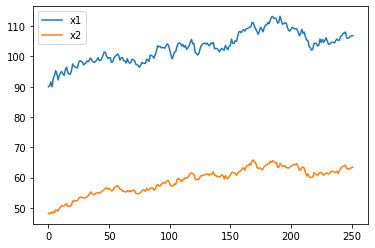

In [16]:
# exploration pairs
plot_pair('IDA','XEL')
pairs = [('IDA','XEL'),('LMT','MANH'),('SKY','LMT'),('NVDA','GOOGL'),
         ('PRFT','TPX'),('GPN','SNPS'),('AWK','WEC'),('PPG', 'CRH'),
         ('EVER', 'BMCH'),('ACWX','IXUS'),('SUI','ETR'),('KBR','MSFT'),
         ('GIB','MSFT'),('CEIX','KLXE'),('Y', 'ORA'),('EQIX', 'AWK')]

In [17]:
# Obtain the statistical parameters for each and every pair
data_analysis = {'Pairs': [],
                 'Constant': [],
                 'Gamma': [],
                 'Alpha': [],
                 'P-Value': []}

data_zvalues = {}

# loop over pairs to get parameters
for pair in pairs:
    stock1, stock2 = pair
    y = np.log(train['PRC',stock1]).dropna()
    x = np.log(train['PRC',stock2]).dropna()
    
    # run long-short relationship to get parameters
    constant = estimate_long_run_short_run_relationships(y,x)[0]
    gamma = estimate_long_run_short_run_relationships(y,x)[1]
    alpha = estimate_long_run_short_run_relationships(y,x)[2]
    pvalue = engle_granger_two_step_cointegration_test(y,x)[1]
    zvalue = estimate_long_run_short_run_relationships(y,x)[3]
    
    # save parameters
    data_analysis['Pairs'].append(pair)
    data_analysis['Constant'].append(constant)
    data_analysis['Gamma'].append(gamma)
    data_analysis['Alpha'].append(alpha)
    data_analysis['P-Value'].append(pvalue)

    data_zvalues[pair] = zvalue
    
# organize output into dataframe
data_analysis = round(pd.DataFrame(data_analysis),4).set_index('Pairs')
data_analysis

,Constant,Gamma,Alpha,P-Value
Pairs,,,,
"(IDA, XEL)",2.0494,0.6345,-0.0920,0.0178
"(LMT, MANH)",3.5659,0.5389,-0.0530,0.0639
"(SKY, LMT)",-7.6326,1.8531,-0.1374,0.0037
"(NVDA, GOOGL)",-6.3309,1.6199,-0.0330,0.0003
"(PRFT, TPX)",-0.3197,0.9001,-0.0916,0.0095
"(GPN, SNPS)",0.4880,0.9393,-0.0413,0.0806
"(AWK, WEC)",0.2538,1.0093,-0.0103,0.4930
"(PPG, CRH)",2.1909,0.7305,-0.1447,0.0014
"(EVER, BMCH)",-6.7995,3.0332,-0.0416,0.2796


In [18]:
# explore tradable pairs, p < .01
tradable_pairs_analysis = data_analysis[data_analysis['P-Value'] < 0.01].sort_values('P-Value')
#tradable_pairs_analysis.append(data_analysis['LMT', 'MANH'])

# Get all the tradable stock pairs into a list
stock_pairs = list(tradable_pairs_analysis.index.values.tolist())
#stock_pairs += [('LMT', 'MANH')]

# Create a list of unique tradable stocks
list_stock1 = [stock[0] for stock in stock_pairs]
list_stock2 = [stock[1] for stock in stock_pairs]

for stock in list_stock2:
    list_stock1.append(stock)
    
unique_stock_list = list(set(list_stock1))

# creat training dfs of only tradable stocks
t = train['PRC']
tradable_pairs_prc = t[unique_stock_list]
t = train['VOL']
tradable_pairs_vol = t[unique_stock_list]
t = train['BID']
tradable_pairs_bid = t[unique_stock_list]
t = train['ASK']
tradable_pairs_ask = t[unique_stock_list]

tradable_pairs_prc.head()

TICKER,ETR,TPX,CRH,ACWX,PRFT,GOOGL,IXUS,LMT,AWK,KBR,SKY,NVDA,ORA,MSFT,Y,SUI,EQIX,GIB,PPG
date,,,,,,,,,,,,,,,,,,,
2019-01-02,84.00,41.98,26.39,41.81,22.11,1054.68005,52.38,264.73001,88.77,15.71,14.75,136.22000,51.71,101.12,615.72998,97.79,350.00000,61.19,101.69
2019-01-03,84.17,41.07,26.05,41.42,21.92,1025.46997,51.94,258.07999,89.12,15.53,14.24,127.99000,50.83,97.40,609.23999,98.96,345.94000,59.56,97.97
2019-01-04,84.80,42.21,27.55,42.70,22.32,1078.06995,53.52,265.04001,89.79,16.55,14.99,136.19000,52.42,101.93,624.04999,99.41,353.79001,60.69,99.91
2019-01-07,84.40,44.29,27.35,42.76,22.62,1075.92004,53.74,268.07999,88.84,16.90,15.97,143.39999,52.72,102.06,616.53003,99.81,354.50000,61.56,100.24
2019-01-08,85.90,47.03,27.51,43.04,23.18,1085.37000,54.08,269.87000,90.14,17.15,15.76,139.83000,53.24,102.80,614.67999,101.36,361.85999,62.88,101.07


In [19]:
# Create a Dataframe containing information about the error-correction 
# term of each pair
data_error_correction_term = {'Pair': [],
                              'CountZeroCrossings': [],
                              'TradingPeriod': [],
                              'LongRunMean': [],
                              'Std': []}

for pair in stock_pairs:
    zvalue = data_zvalues[pair]
    my_array = np.array(zvalue)
    count = ((my_array[:-1] * my_array[1:]) < 0).sum()
    trading_period = 1 / count
    long_run_mean = zvalue.mean()
    std = zvalue.std()

    data_error_correction_term['Pair'].append(pair)
    data_error_correction_term['CountZeroCrossings'].append(count)
    data_error_correction_term['TradingPeriod'].append(trading_period)
    data_error_correction_term['LongRunMean'].append(round(long_run_mean, 4))
    data_error_correction_term['Std'].append(round(std, 4))

data_error_correction_term = pd.DataFrame(data_error_correction_term).set_index('Pair')

data_error_correction_term

,CountZeroCrossings,TradingPeriod,LongRunMean,Std
Pair,,,,
"(ACWX, IXUS)",69,0.014493,0.0,0.0009
"(Y, ORA)",39,0.025641,0.0,0.0178
"(NVDA, GOOGL)",25,0.040000,0.0,0.0529
"(EQIX, AWK)",31,0.032258,-0.0,0.0250
"(SUI, ETR)",33,0.030303,-0.0,0.0191
"(KBR, MSFT)",35,0.028571,0.0,0.0319
"(PPG, CRH)",38,0.026316,-0.0,0.0208
"(SKY, LMT)",35,0.028571,0.0,0.0556
"(GIB, MSFT)",21,0.047619,-0.0,0.0167


In [20]:
# Create a Dictionary that saves all Gamma values of each pair
gamma_dictionary = {}

for pair, value in tradable_pairs_analysis.iterrows():
    gamma_dictionary[pair]= value['Gamma']
    
# Create a Dictionary that saves all Standard Deviation values of each pair
std_dictionary = {}

for pair, value in data_error_correction_term.iterrows():
    std_dictionary[pair]= value['Std']

In [21]:
positions = {}
limit = 100

for pair in stock_pairs:
    stock1, stock2 = pair
    
    gamma = gamma_dictionary[stock1,stock2]
    
    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1,stock2]
        
        current_position_stock1 = 0 
        current_position_stock2 = 0 
        
        column_name_stock1 = stock1 + ' Pos - Thres: ' + str(threshold)
        
        BidPrice_Stock1 = tradable_pairs_bid[stock1].iloc[0]
        AskPrice_Stock1 = tradable_pairs_ask[stock1].iloc[0]
        BidPrice_Stock2 = tradable_pairs_bid[stock2].iloc[0]
        AskPrice_Stock2 = tradable_pairs_ask[stock2].iloc[0]
        
        positions[column_name_stock1] = []
        
        for time, data_at_time in tradable_pairs_vol.iterrows():
            
            BidVolume_Stock1 = data_at_time[stock1]
            AskVolume_Stock1 = data_at_time[stock1]
            BidVolume_Stock2 = data_at_time[stock2]
            AskVolume_Stock2 = data_at_time[stock2]
            
            zvalue = data_zvalues[pair][time]

            # If the zvalues of (BB,DD) are high the spread diverges, i.e. sell BB (=stock1=y) and buy DD (=stock2=x)
            if zvalue >= threshold:
                hedge_ratio = gamma * (BidPrice_Stock1 / AskPrice_Stock2)
            
                if hedge_ratio >= 1:

                    max_order_stock1 = current_position_stock1 + limit
                    max_order_stock2 = max_order_stock1 / hedge_ratio

                    trade = np.floor(min((BidVolume_Stock1 / hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((- trade * hedge_ratio) + current_position_stock1)

                    current_position_stock1 = ((- trade * hedge_ratio) + current_position_stock1)
                
                elif hedge_ratio < 1:

                    max_order_stock1 = current_position_stock1 + limit
                    max_order_stock2 = max_order_stock1 * hedge_ratio

                    trade = np.floor(min((BidVolume_Stock1 * hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((- trade / hedge_ratio) + current_position_stock1)

                    current_position_stock1 = ((- trade / hedge_ratio) + current_position_stock1)

            elif zvalue <= -threshold:
                hedge_ratio = gamma * (AskPrice_Stock1 / BidPrice_Stock2)
                
                if hedge_ratio >= 1:

                    max_order_stock1 = abs(current_position_stock1 - limit)
                    max_order_stock2 = max_order_stock1 / hedge_ratio

                    trade = np.floor(min((AskVolume_Stock1 / hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((+ trade * hedge_ratio) + current_position_stock1)

                    current_position_stock1 = (+ trade * hedge_ratio) + current_position_stock1

                elif hedge_ratio < 1:
                    
                    max_order_stock1 = abs(current_position_stock1 - limit)
                    max_order_stock2 = max_order_stock1 * hedge_ratio

                    trade = np.floor(min((AskVolume_Stock1 * hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                    positions[column_name_stock1].append((+ trade / hedge_ratio) + current_position_stock1)

                    current_position_stock1 = (+ trade / hedge_ratio) + current_position_stock1  
                
                BidPrice_Stock1 = tradable_pairs_bid.loc[time,stock1]
                AskPrice_Stock1 = tradable_pairs_ask.loc[time,stock1]
                BidPrice_Stock2 = tradable_pairs_bid.loc[time,stock2]
                AskPrice_Stock2 = tradable_pairs_ask.loc[time,stock2]

            else:
                    positions[column_name_stock1].append(current_position_stock1)
        
        column_name_stock2 = stock2 + ' Pos - Thres: ' + str(threshold)
        
        if hedge_ratio >= 1:
            positions[column_name_stock2] = positions[column_name_stock1] / hedge_ratio * -1
        
        elif hedge_ratio < 1:
            positions[column_name_stock2] = positions[column_name_stock1] / (1 / hedge_ratio) * -1
            

In [22]:
# Create a seperate dataframe (to keep the original dataframe intact) with rounding
# Also insert the timestamp, as found in the tradeable_pairs_data DataFrame
positions_final = np.ceil(pd.DataFrame(positions))
positions_final['Timestamp'] = tradable_pairs_prc.index
positions_final = positions_final.set_index('Timestamp')

# The difference between the positions
positions_diff = positions_final.diff()[1:]

# Positions_diff first rows
positions_diff.head()

positions_diff[-1:] = -positions_final[-1:]

In [23]:
pnl_dataframe = pd.DataFrame()

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
        
    Stock1_AskPrice = tradable_pairs_ask[stock1].iloc[1:]
    Stock1_BidPrice = tradable_pairs_bid[stock1].iloc[1:]
    Stock2_AskPrice = tradable_pairs_ask[stock2].iloc[1:]
    Stock2_BidPrice = tradable_pairs_bid[stock2].iloc[1:]

    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1, stock2]

        column_name_1 = stock1 + ' Pos - Thres: ' + str(threshold)
        column_name_2 = stock2 + ' Pos - Thres: ' + str(threshold)

        pnl_dataframe[stock1 + str(threshold)] = np.where(positions_diff[column_name_1] > 0,
                                                          positions_diff[column_name_1] * -Stock1_BidPrice, positions_diff[column_name_1] * -Stock1_AskPrice)
        pnl_dataframe[stock2 + str(threshold)] = np.where(positions_diff[column_name_2] > 0,
                                                          positions_diff[column_name_2] * -Stock2_BidPrice, positions_diff[column_name_2] * -Stock2_AskPrice)

pnl_dataframe.head()

,ACWX4.5e-05,IXUS4.5e-05,ACWX0.00014,IXUS0.00014,ACWX0.00023500000000000002,IXUS0.00023500000000000002,ACWX0.00032999999999999994,IXUS0.00032999999999999994,ACWX0.000425,IXUS0.000425,...,PRFT0.021840000000000002,TPX0.021840000000000002,PRFT0.025830000000000002,TPX0.025830000000000002,PRFT0.029820000000000003,TPX0.029820000000000003,PRFT0.03381,TPX0.03381,PRFT0.0378,TPX0.0378
0,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,-8509.24,8543.07,-8509.24,8543.07,-8509.24,8543.07,-8509.24,8543.07,-8509.24,8543.07,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [24]:
# Create Columns for the pnl_threshold dataframe
pairs = []
thresholds = []

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1, stock2]
        pair = stock1, stock2
        pairs.append(pair)
        thresholds.append(threshold)

# Include columns and append PnLs
pnl_threshold = {'Pairs' : pairs,
                 'Thresholds': thresholds,
                 'PnLs' : []}

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1,stock2]
        pnl_threshold['PnLs'].append(pnl_dataframe[stock1 + str(threshold)].sum() + pnl_dataframe[stock2 + str(threshold)].sum())
        
pnl_threshold = pd.DataFrame(pnl_threshold)
#pnl_threshold = pnl_threshold.set_index('Pairs')
# pnl_threshold.to_excel('Thresholds.xlsx')

# Find Highest PnLs
highest_pnls = pnl_threshold.groupby(by=['Pairs']).agg({'PnLs' : max})
highest_pnls.sort_values('PnLs', ascending=False)

,PnLs
Pairs,
"(Y, ORA)",113289.60959
"(EQIX, AWK)",54224.81547
"(NVDA, GOOGL)",19465.37220
"(SUI, ETR)",9275.34505
"(GIB, MSFT)",4008.58300
"(SKY, LMT)",2922.38016
"(PRFT, TPX)",2508.88000
"(KBR, MSFT)",2504.63224
"(ACWX, IXUS)",304.52000


In [25]:
# Select thresholds
# Dropped '(ACWX, IXUS)' pairing because they are ETFs
pnl_threshold = pnl_threshold[pnl_threshold["Pairs"] != ('ACWX', 'IXUS')]
pnl_threshold = pnl_threshold[pnl_threshold["PnLs"] > 0]
stock_pairs_final = pnl_threshold["Pairs"].unique().tolist()

threshold_dictionary = {}
for pairing in stock_pairs_final:
    single_pair_df = pnl_threshold[pnl_threshold["Pairs"] == pairing]
    single_pair_df = single_pair_df.reset_index()
    max_pnl = single_pair_df["PnLs"].max()
    for row in range(len(single_pair_df)):
        if single_pair_df["PnLs"][row] == max_pnl:
            threshold_dictionary[pairing] = round(single_pair_df["Thresholds"][row],7)
                
threshold_dictionary, stock_pairs_final

({('Y', 'ORA'): 0.0084056,
  ('NVDA', 'GOOGL'): 0.0417322,
  ('EQIX', 'AWK'): 0.0038889,
  ('SUI', 'ETR'): 0.0170839,
  ('KBR', 'MSFT'): 0.001595,
  ('SKY', 'LMT'): 0.0145178,
  ('GIB', 'MSFT'): 0.0043606,
  ('PRFT', 'TPX'): 0.00189},
 [('Y', 'ORA'),
  ('NVDA', 'GOOGL'),
  ('EQIX', 'AWK'),
  ('SUI', 'ETR'),
  ('KBR', 'MSFT'),
  ('SKY', 'LMT'),
  ('GIB', 'MSFT'),
  ('PRFT', 'TPX')])

In [26]:
threshold_dictionary = {('Y', 'ORA'): 0.0084056,
  ('NVDA', 'GOOGL'): 0.0417322,
  #('EQIX', 'AWK'): 0.0038889,
  ('SUI', 'ETR'): 0.0170839,
  ('KBR', 'MSFT'): 0.001595,
  ('SKY', 'LMT'): 0.0145178,
  ('GIB', 'MSFT'): 0.0043606,
  ('PRFT', 'TPX'): 0.00189}

stock_pairs_final = [('Y', 'ORA'),
  ('NVDA', 'GOOGL'),
  #('EQIX', 'AWK'),
  ('SUI', 'ETR'),
  ('KBR', 'MSFT'),
  ('SKY', 'LMT'),
  ('GIB', 'MSFT'),
  ('PRFT', 'TPX')]

### Exectute trades on test timeseries

In [27]:
# creat testing dfs of only tradable stocks
t = test['PRC']
tradable_pairs_prc = t[unique_stock_list]
t = test['VOL']
tradable_pairs_vol = t[unique_stock_list]
t = test['BID']
tradable_pairs_bid = t[unique_stock_list]
t = test['ASK']
tradable_pairs_ask = t[unique_stock_list]

In [28]:
positions_strategy_1 = {}
limit = 100

data_zvalues = {}
for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    gamma = gamma_dictionary[stock1,stock2]
    
    threshold = threshold_dictionary[stock1,stock2]
    
    # get updated z-values
    y = np.log(temp3['PRC',stock1]).dropna()
    x = np.log(temp3['PRC',stock2]).dropna()
    zvalue = estimate_long_run_short_run_relationships(y,x)[3]
    data_zvalues[pair] = zvalue
        
    current_position_stock1 = 0 
    current_position_stock2 = 0 
        
    positions_strategy_1[stock1] = []

    for time, data_at_time in tradable_pairs_vol.iterrows():
        
        '''
        # to potentally account for news/earning reports
        if time in reports['times']:
            if pair == reports.loc[time,'pair']:
                break
        '''
        
        BidPrice_Stock1 = tradable_pairs_bid.loc[time,stock1]
        AskPrice_Stock1 = tradable_pairs_ask.loc[time,stock1]
        BidPrice_Stock2 = tradable_pairs_bid.loc[time,stock2]
        AskPrice_Stock2 = tradable_pairs_ask.loc[time,stock2]

        BidVolume_Stock1 = data_at_time[stock1]
        AskVolume_Stock1 = data_at_time[stock1]
        BidVolume_Stock2 = data_at_time[stock2]
        AskVolume_Stock2 = data_at_time[stock2]

        zvalue = data_zvalues[pair][time]

        if zvalue >= threshold:
            hedge_ratio = gamma * (BidPrice_Stock1 / AskPrice_Stock2)
                
            if hedge_ratio >= 1:

                max_order_stock1 = current_position_stock1 + limit
                max_order_stock2 = max_order_stock1 / hedge_ratio

                trade = np.floor(min((BidVolume_Stock1 / hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((- trade * hedge_ratio) + current_position_stock1)

                current_position_stock1 = ((- trade * hedge_ratio) + current_position_stock1)
                
            elif hedge_ratio < 1:

                max_order_stock1 = current_position_stock1 + limit
                max_order_stock2 = max_order_stock1 * hedge_ratio

                trade = np.floor(min((BidVolume_Stock1 * hedge_ratio), AskVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((- trade / hedge_ratio) + current_position_stock1)

                current_position_stock1 = ((- trade / hedge_ratio) + current_position_stock1)

        elif zvalue <= -threshold:
            hedge_ratio = gamma * (AskPrice_Stock1 / BidPrice_Stock2)
                
            if hedge_ratio >= 1:

                max_order_stock1 = abs(current_position_stock1 - limit)
                max_order_stock2 = max_order_stock1 / hedge_ratio

                trade = np.floor(min((AskVolume_Stock1 / hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((+ trade * hedge_ratio) + current_position_stock1)

                current_position_stock1 = (+ trade * hedge_ratio) + current_position_stock1

            elif hedge_ratio < 1:
                    
                max_order_stock1 = abs(current_position_stock1 - limit)
                max_order_stock2 = max_order_stock1 * hedge_ratio

                trade = np.floor(min((AskVolume_Stock1 * hedge_ratio), BidVolume_Stock2, max_order_stock1, max_order_stock2))

                positions_strategy_1[stock1].append((+ trade / hedge_ratio) + current_position_stock1)

                current_position_stock1 = (+ trade / hedge_ratio) + current_position_stock1   

        else:

                positions_strategy_1[stock1].append(current_position_stock1)
                
    if hedge_ratio >= 1:
        positions_strategy_1[stock2] = positions_strategy_1[stock1] / hedge_ratio * -1
        
    elif hedge_ratio < 1:
        positions_strategy_1[stock2] = positions_strategy_1[stock1] / (1 / hedge_ratio) * -1

In [29]:
positions_strategy_1 = np.ceil(pd.DataFrame(positions_strategy_1))
positions_strategy_1['Timestamp'] = tradable_pairs_prc.index
positions_strategy_1 = positions_strategy_1.set_index('Timestamp')

# The difference between the positions
positions_diff_strategy_1 = positions_strategy_1.diff()[1:]

# # Positions_diff first rows
# positions_diff_strategy_1.head()

#Used as mentioned earlier.
positions_diff_strategy_1[-1:] = -positions_strategy_1[-1:]

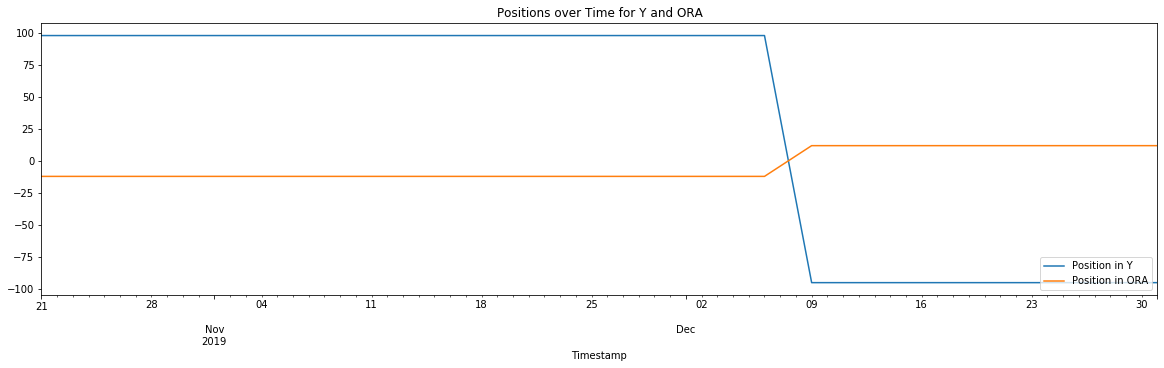

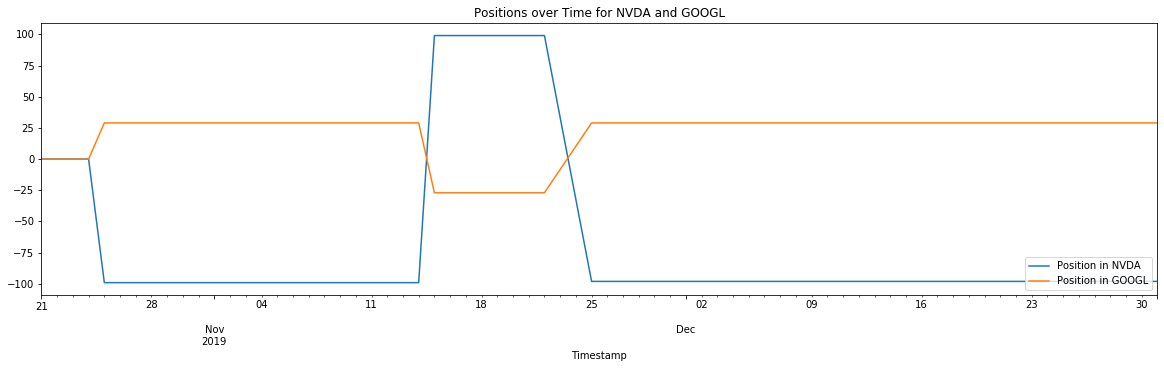

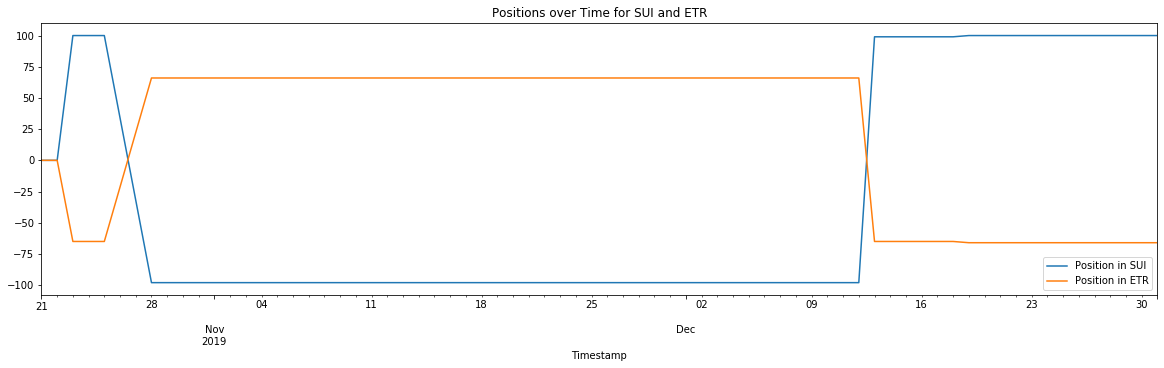

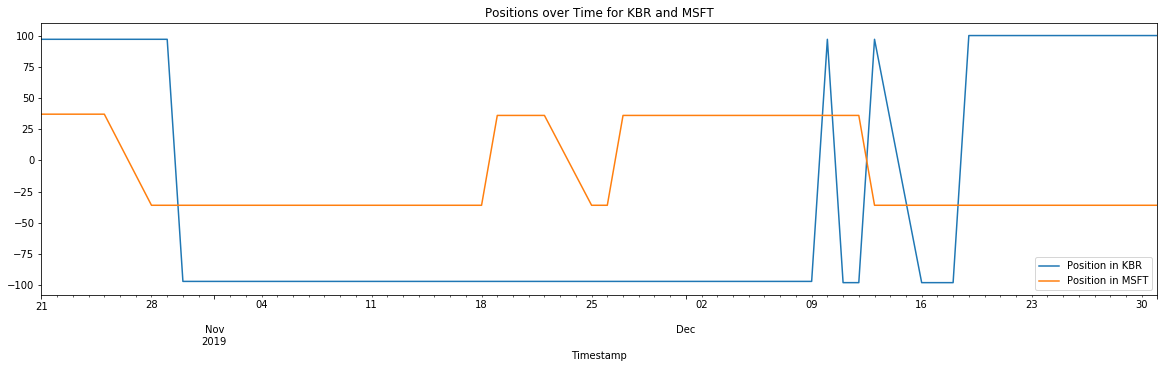

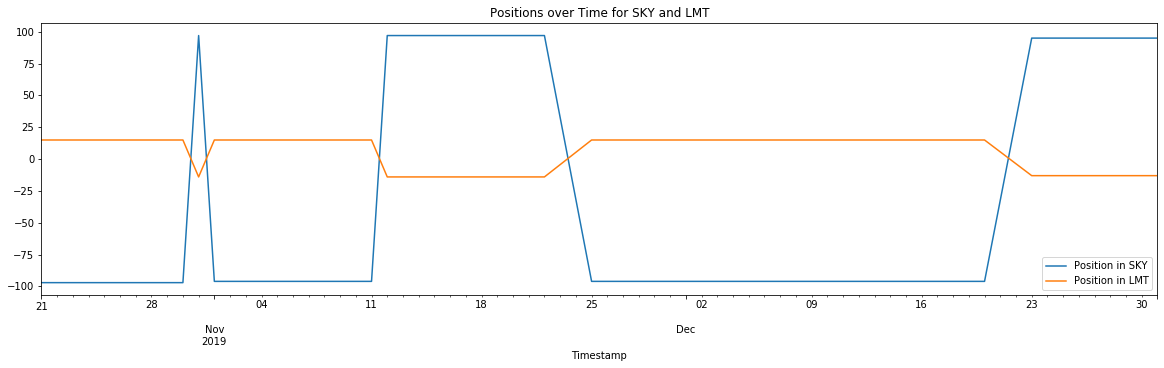

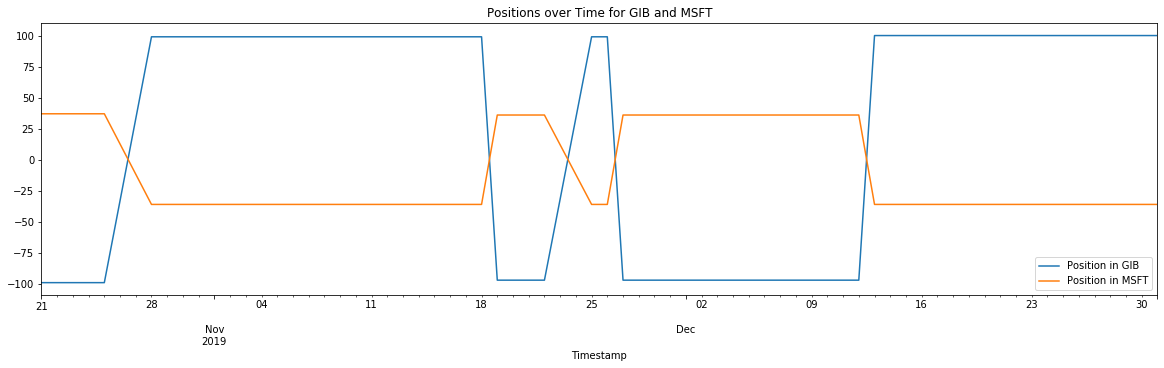

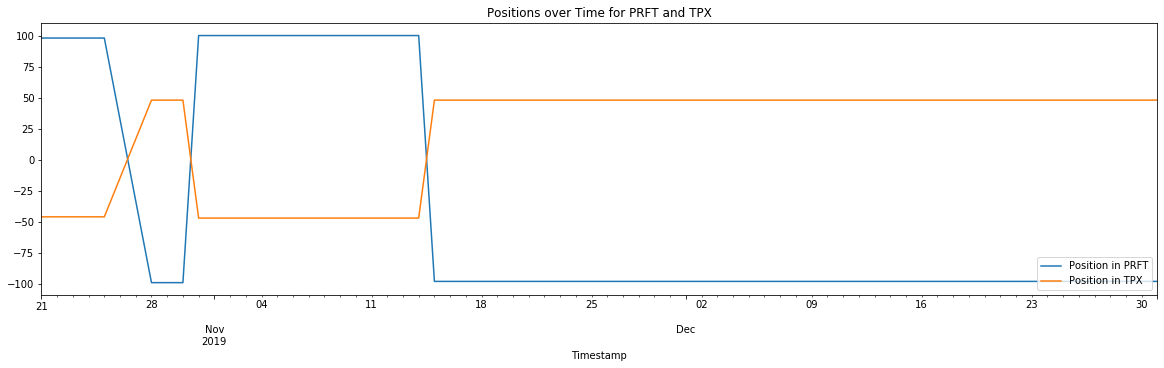

In [30]:
# Show Positions over Time
for pairs in stock_pairs_final:
    stock1 = pairs[0]
    stock2 = pairs[1]
    
    plt.figure(figsize=(20,5))
    
    positions_strategy_1[stock1].plot()
    positions_strategy_1[stock2].plot()
    
    plt.title('Positions over Time for ' + stock1 + ' and ' + stock2)
    plt.legend(["Position in " + stock1,"Position in " + stock2], loc='lower right')
    
    plt.show()

In [32]:
pnl_dataframe_strategy_1 = pd.DataFrame()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    Stock1_AskPrice = tradable_pairs_ask[stock1].iloc[1:]
    Stock1_BidPrice = tradable_pairs_bid[stock1].iloc[1:]
    Stock2_AskPrice = tradable_pairs_ask[stock2].iloc[1:]
    Stock2_BidPrice = tradable_pairs_bid[stock2].iloc[1:]

    pnl_dataframe_strategy_1[stock1] = np.where(positions_diff_strategy_1[stock1] > 0, positions_diff_strategy_1[stock1] * -Stock1_BidPrice, positions_diff_strategy_1[stock1] * -Stock1_AskPrice)
    pnl_dataframe_strategy_1[stock2] = np.where(positions_diff_strategy_1[stock2] > 0, positions_diff_strategy_1[stock2] * -Stock2_BidPrice, positions_diff_strategy_1[stock2] * -Stock2_AskPrice)

print("The total profit is: $",round(pnl_dataframe_strategy_1.sum().sum()))

The total profit is: $ 86122.0


In [33]:
pnl_dataframe_strategy_1['Timestamp'] = tradable_pairs_prc.index[1:]
pnl_dataframe_strategy_1 = pnl_dataframe_strategy_1.set_index('Timestamp')

pnl_dataframe_strategy_1['PnL'] = pnl_dataframe_strategy_1.sum(axis=1)
pnl_dataframe_strategy_1['Cum PnL'] = pnl_dataframe_strategy_1['PnL'].cumsum()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]

    pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'] = pnl_dataframe_strategy_1[stock1] + pnl_dataframe_strategy_1[stock2]
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'] = pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'].cumsum()

pnl_dataframe_strategy_1.tail()

,Y,ORA,NVDA,GOOGL,SUI,ETR,KBR,MSFT,SKY,LMT,...,SUIETR PnL,SUIETR Cum PnL,KBRMSFT PnL,KBRMSFT Cum PnL,SKYLMT PnL,SKYLMT Cum PnL,GIBMSFT PnL,GIBMSFT Cum PnL,PRFTTPX PnL,PRFTTPX Cum PnL
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-24,-0.00000,-0.00,-0.00000,-0.00000,-0.0,-0.00,-0.0,-0.00,-0.00,-0.00000,...,-0.00,-6407.51803,-0.00,10799.26,-0.00000,6044.34000,-0.00,-4634.20,-0.00,931.19
2019-12-26,-0.00000,-0.00,-0.00000,-0.00000,-0.0,-0.00,-0.0,-0.00,-0.00,-0.00000,...,-0.00,-6407.51803,-0.00,10799.26,-0.00000,6044.34000,-0.00,-4634.20,-0.00,931.19
2019-12-27,-0.00000,-0.00,-0.00000,-0.00000,-0.0,-0.00,-0.0,-0.00,-0.00,-0.00000,...,-0.00,-6407.51803,-0.00,10799.26,-0.00000,6044.34000,-0.00,-4634.20,-0.00,931.19
2019-12-30,-0.00000,-0.00,-0.00000,-0.00000,-0.0,-0.00,-0.0,-0.00,-0.00,-0.00000,...,-0.00,-6407.51803,-0.00,10799.26,-0.00000,6044.34000,-0.00,-4634.20,-0.00,931.19
2019-12-31,-76046.54905,894.12,-23064.30098,38832.74174,15011.0,-7902.84,3051.0,-5669.28,3012.45,-5059.99013,...,7108.16,700.64197,-2618.28,8180.98,-2047.54013,3996.79987,2705.72,-1928.48,-332.58,598.61


In [38]:
pnl_dataframe_strategy_1.iloc[:,:20]

,Y,ORA,NVDA,GOOGL,SUI,ETR,KBR,MSFT,SKY,LMT,GIB,PRFT,TPX,PnL,Cum PnL,YORA PnL,YORA Cum PnL,NVDAGOOGL PnL,NVDAGOOGL Cum PnL,SUIETR PnL
Timestamp,,,,,,,,,,,,,,,,,,,,
2019-10-22,-0.00000,-0.00,-0.00000,-0.00000,-0.00000,-0.00,-0.00,-0.00,-0.00,-0.00000,-0.00,-0.00,-0.00,0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000
2019-10-23,-0.00000,-0.00,-0.00000,-0.00000,-15488.00000,7842.90,-0.00,-0.00,-0.00,-0.00000,-0.00,-0.00,-0.00,-7645.10000,-7645.10000,-0.00000,-0.00000,-0.00000,-0.00000,-7645.10000
2019-10-24,-0.00000,-0.00,-0.00000,-0.00000,-0.00000,-0.00,-0.00,-0.00,-0.00,-0.00000,-0.00,-0.00,-0.00,0.00000,-7645.10000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000
2019-10-25,-0.00000,-0.00,20247.48000,-36663.83058,-0.00000,-0.00,-0.00,-0.00,-0.00,-0.00000,-0.00,-0.00,-0.00,-16416.35058,-24061.45058,-0.00000,-0.00000,-16416.35058,-16416.35058,-0.00000
2019-10-28,-0.00000,-0.00,-0.00000,-0.00000,31396.86198,-15475.03,-0.00,10526.60,-0.00,-0.00000,-15501.42,7736.19,-7614.00,11069.20198,-12992.24860,-0.00000,-0.00000,-0.00000,-16416.35058,15921.83198
2019-10-29,-0.00000,-0.00,-0.00000,-0.00000,-0.00000,-0.00,-0.00,-0.00,-0.00,-0.00000,-0.00,-0.00,-0.00,0.00000,-12992.24860,-0.00000,-0.00000,-0.00000,-16416.35058,-0.00000
2019-10-30,-0.00000,-0.00,-0.00000,-0.00000,-0.00000,-0.00,5672.56,-0.00,-0.00,-0.00000,-0.00,-0.00,-0.00,5672.56000,-7319.68860,-0.00000,-0.00000,-0.00000,-16416.35058,-0.00000
2019-10-31,-0.00000,-0.00,-0.00000,-0.00000,-0.00000,-0.00,-0.00,-0.00,-5470.80,10926.04029,-0.00,-7790.85,8643.10,6307.49029,-1012.19831,-0.00000,-0.00000,-0.00000,-16416.35058,-0.00000
2019-11-01,-0.00000,-0.00,-0.00000,-0.00000,-0.00000,-0.00,-0.00,-0.00,6137.40,-10989.55029,-0.00,-0.00,-0.00,-4852.15029,-5864.34860,-0.00000,-0.00000,-0.00000,-16416.35058,-0.00000


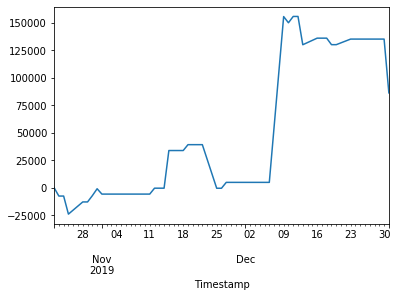

In [34]:
pnl_dataframe_strategy_1['Cum PnL'].plot()

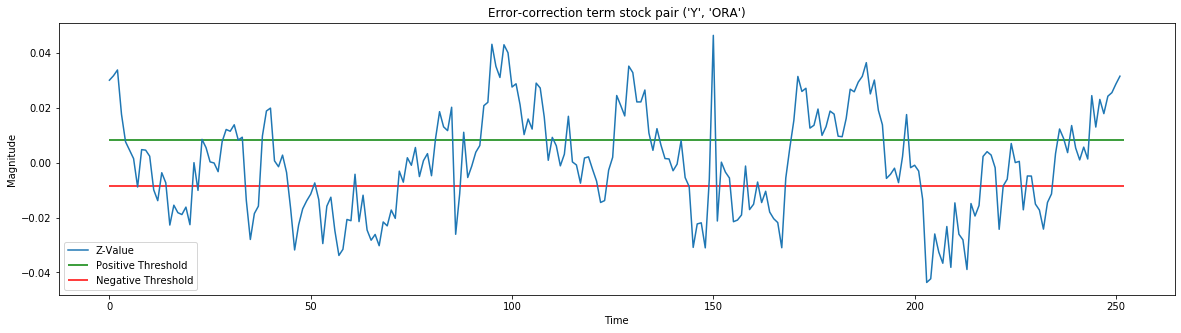

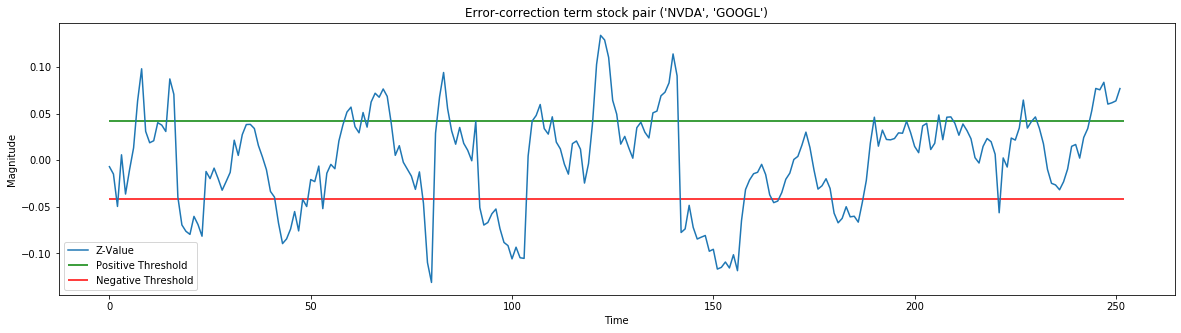

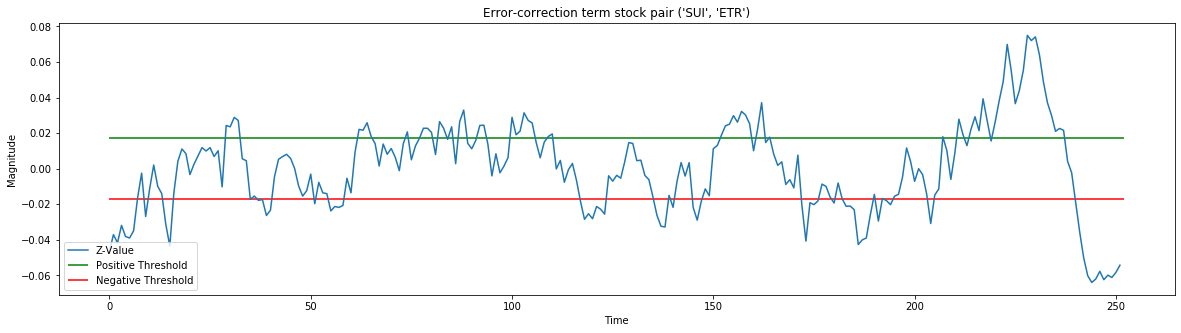

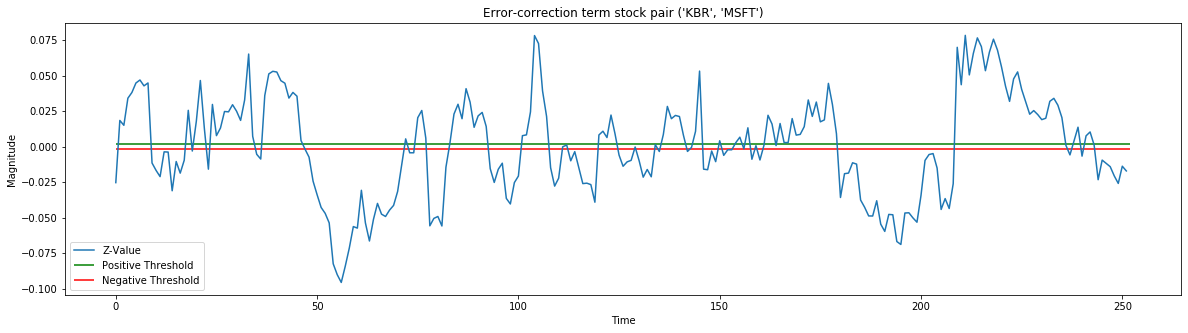

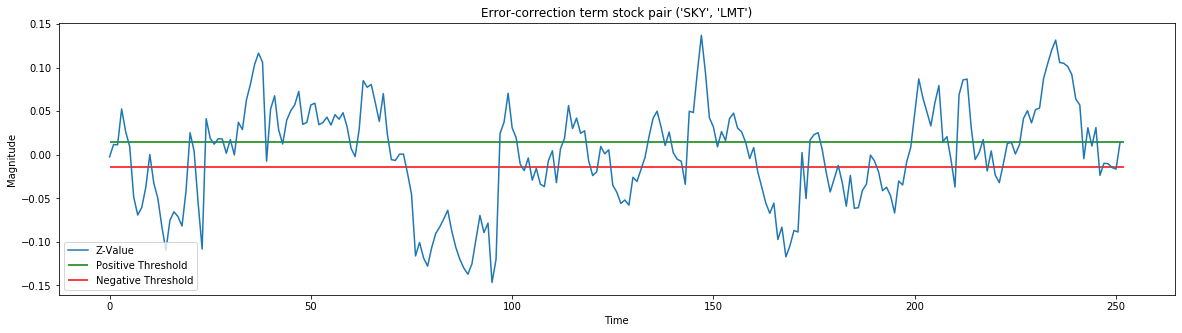

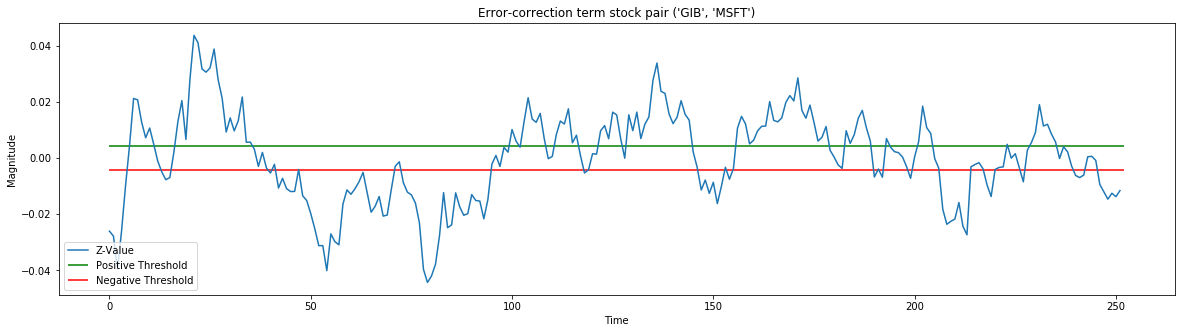

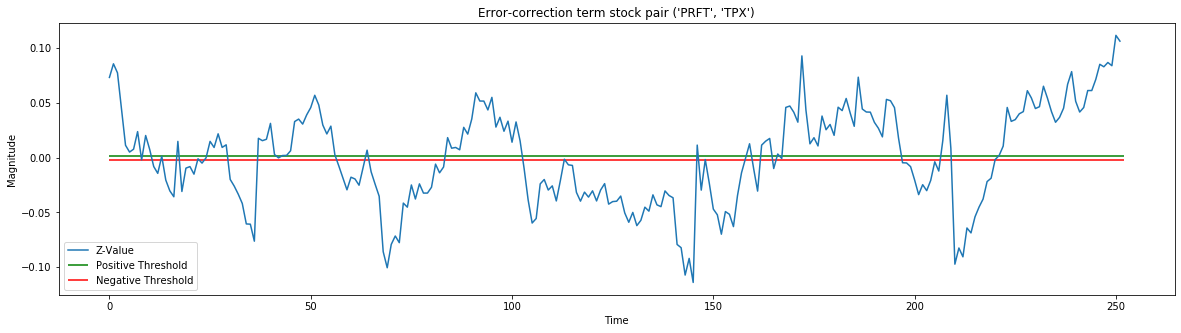

In [35]:
Plot_Tradable_Z()

In [36]:
positions_strategy_1#.plot(figsize=(20,10))

,Y,ORA,NVDA,GOOGL,SUI,ETR,KBR,MSFT,SKY,LMT,GIB,PRFT,TPX
Timestamp,,,,,,,,,,,,,
2019-10-21,98.0,-12.0,0.0,-0.0,0.0,-0.0,97.0,37.0,-97.0,15.0,-99.0,98.0,-46.0
2019-10-22,98.0,-12.0,0.0,-0.0,0.0,-0.0,97.0,37.0,-97.0,15.0,-99.0,98.0,-46.0
2019-10-23,98.0,-12.0,0.0,-0.0,100.0,-65.0,97.0,37.0,-97.0,15.0,-99.0,98.0,-46.0
2019-10-24,98.0,-12.0,0.0,-0.0,100.0,-65.0,97.0,37.0,-97.0,15.0,-99.0,98.0,-46.0
2019-10-25,98.0,-12.0,-99.0,29.0,100.0,-65.0,97.0,37.0,-97.0,15.0,-99.0,98.0,-46.0
2019-10-28,98.0,-12.0,-99.0,29.0,-98.0,66.0,97.0,-36.0,-97.0,15.0,99.0,-99.0,48.0
2019-10-29,98.0,-12.0,-99.0,29.0,-98.0,66.0,97.0,-36.0,-97.0,15.0,99.0,-99.0,48.0
2019-10-30,98.0,-12.0,-99.0,29.0,-98.0,66.0,-97.0,-36.0,-97.0,15.0,99.0,-99.0,48.0
2019-10-31,98.0,-12.0,-99.0,29.0,-98.0,66.0,-97.0,-36.0,97.0,-14.0,99.0,100.0,-47.0


In [12]:
from math import sqrt

SP500 = pd.read_csv('SP500_compare.csv')
SP500['caldt'] = pd.to_datetime(SP500['caldt'], format='%Y%m%d', errors='ignore')
SP500 = SP500.set_index('caldt')
rf =  .0081

SP_ret_real = SP500['sprtrn'].mean()
#SP_ret_real = (1 + (SP500['sprtrn'].mean()))**252 - 1
SP_sd_real = SP500['sprtrn'].std()
SP_sharpe = (SP_ret_real) / SP_sd_real

metrics = pd.DataFrame(data = {'daily return': [SP_ret_real], 'sd': [SP_sd_real], 'sharpe': [SP_sharpe]}).rename({0:"SP500"})
metrics

,daily return,sd,sharpe
SP500,0.000421,0.009418,0.044683


In [13]:
hpr = (105808 - 10000)/10000
hpr
annual_return = (hpr) * (252/50)
daily = annual_return/252
daily
our_metrics = pd.DataFrame(data = {'daily return': [daily], 'sd': [''], 'sharpe': [0]}).rename({0:"Stat Arb"})
metrics = metrics.append(our_metrics)
metrics

,daily return,sd,sharpe
SP500,0.000421,0.009418,0.044683
Stat Arb,0.191616,0.000000,0.000000
